# The final model
 

## Model v2.0

In [10]:
model_name = f'3.31-v2.0'

In [11]:
import warnings

from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")

In [12]:
import pandas as pd
from data import load_data

_, augmented_data, test_data = load_data()

In [13]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [15]:
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [16]:
import dnns
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

create_dnn_model = dnns.create_model_MA01


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights(f'{model_name}.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[dnns.rmse]
    )
    return dnn


Epoch 1/100
4215/4215 - 7s - 2ms/step - loss: 11.8310 - rmse: 3.1130 - val_loss: 5.7801 - val_rmse: 2.1314
Epoch 2/100
4215/4215 - 5s - 1ms/step - loss: 6.0670 - rmse: 2.4316 - val_loss: 5.2758 - val_rmse: 2.0394
Epoch 3/100
4215/4215 - 6s - 1ms/step - loss: 5.7489 - rmse: 2.3658 - val_loss: 5.2494 - val_rmse: 2.0414
Epoch 4/100
4215/4215 - 6s - 1ms/step - loss: 5.5216 - rmse: 2.3188 - val_loss: 5.1933 - val_rmse: 2.0226
Epoch 5/100
4215/4215 - 6s - 1ms/step - loss: 5.3573 - rmse: 2.2826 - val_loss: 5.2464 - val_rmse: 2.0414
Epoch 6/100
4215/4215 - 6s - 1ms/step - loss: 5.2186 - rmse: 2.2550 - val_loss: 5.2344 - val_rmse: 2.0453
Epoch 7/100
4215/4215 - 6s - 1ms/step - loss: 5.0921 - rmse: 2.2258 - val_loss: 5.0418 - val_rmse: 2.0036
Epoch 8/100
4215/4215 - 6s - 1ms/step - loss: 5.0156 - rmse: 2.2102 - val_loss: 5.0289 - val_rmse: 2.0027
Epoch 9/100
4215/4215 - 6s - 1ms/step - loss: 4.9672 - rmse: 2.1987 - val_loss: 5.0509 - val_rmse: 2.0111
Epoch 10/100
4215/4215 - 19s - 5ms/step - los

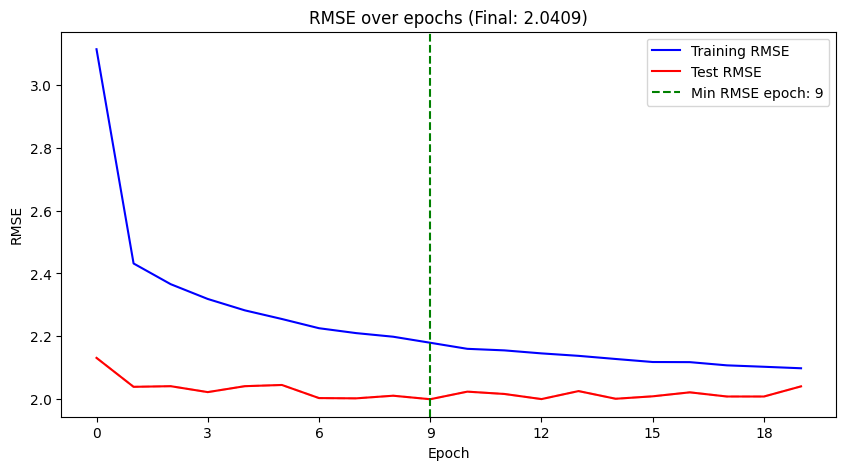

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from tensorflow.keras.callbacks import EarlyStopping
from model_performance_calculations import get_history_line_chart

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=2,
    validation_split=0.2,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

history = pretrained_dnn.history.history
pretrained_dnn.save_weights(f'{model_name}.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', HistGradientBoostingRegressor(max_iter=1000, max_depth=5, learning_rate=0.01)),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=5000, max_depth=5, learning_rate=0.01)),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('lasso', LassoLarsIC(criterion='bic', max_iter=5000)),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

get_history_line_chart([history]).show()

In [ ]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, n_splits=10)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

10:43:11 - Start training
10:43:11 - Calculate performance for hgb
10:43:11 - Split 1 - Model: hgb
10:43:11 - Fitting the model


In [ ]:
import numpy as np
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

In [ ]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

In [ ]:
submission.to_csv(f'submission-model-{model_name}.csv')

In [ ]:
y_pred = model.predict(X_train)

root_mean_squared_error(y_train, y_pred)


In [ ]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_train, y_pred)